# **Time Series Demand Prediction**

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import logging
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

D:\Program Files\Python\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### **Data Reading**

In [2]:
def read_raw_data(file_name):
    # We can think of usage numbers as demand for time-series modeling.
    usage_data = pd.read_csv( os.getcwd() + "/" + file_name)
    return usage_data

In [3]:
usage_data = read_raw_data("municipality_bus_utilization.csv")
usage_data

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019
...,...,...,...,...
13065,2017-08-19 16:30:35,2,548,697
13066,2017-08-19 16:30:35,8,1193,2947
13067,2017-08-19 16:30:35,7,1354,2019
13068,2017-08-19 16:30:35,6,1680,3113


### **Preprocessing and Visualizing Data**

In [4]:
usage_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   timestamp        13070 non-null  object
 1   municipality_id  13070 non-null  int64 
 2   usage            13070 non-null  int64 
 3   total_capacity   13070 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 408.6+ KB


In [5]:
def preprocess_raw_data(usage_data):
    # Changing data type to datetime of timestamp column to work with time-series
    usage_data["timestamp"] = pd.to_datetime(usage_data["timestamp"])

    # Truncating second and milisecond precisions to hour precision for better grouping and vizualization
    usage_data["timestamp"] = usage_data["timestamp"].dt.floor('h')
    
    return usage_data

In [6]:
usage_data = preprocess_raw_data(usage_data)
usage_data

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:00:00,9,454,1332
1,2017-06-04 07:00:00,8,556,2947
2,2017-06-04 07:00:00,4,1090,3893
3,2017-06-04 07:00:00,0,204,2813
4,2017-06-04 07:00:00,7,718,2019
...,...,...,...,...
13065,2017-08-19 16:00:00,2,548,697
13066,2017-08-19 16:00:00,8,1193,2947
13067,2017-08-19 16:00:00,7,1354,2019
13068,2017-08-19 16:00:00,6,1680,3113


In [7]:
def get_municipality_data(usage_data, m_id):
    # Getting data of selected municipality id
    municipality_data = usage_data[usage_data.municipality_id == m_id].sort_values("timestamp", ascending = True)
    # Aggregating max usage value from same timestamp hour and municipiality hour pairs
    municipality_data = municipality_data.groupby(["timestamp", "municipality_id", "total_capacity"]).agg({"usage": "max"}).reset_index()
    return municipality_data

In [8]:
municipality_data = get_municipality_data(usage_data, 0)
municipality_data

,timestamp,municipality_id,total_capacity,usage
0,2017-06-04 07:00:00,0,2813,204
1,2017-06-04 08:00:00,0,2813,332
2,2017-06-04 09:00:00,0,2813,485
3,2017-06-04 10:00:00,0,2813,583
4,2017-06-04 11:00:00,0,2813,614
...,...,...,...,...
669,2017-08-19 12:00:00,0,2813,1281
670,2017-08-19 13:00:00,0,2813,1283
671,2017-08-19 14:00:00,0,2813,1285
672,2017-08-19 15:00:00,0,2813,1286


In [9]:
def visualize_time_series_data(df):
    fig, ax = plt.subplots(figsize=(16, 9))
    sns.lineplot(x = "timestamp", y = "usage", data = df, ax=ax)
    plt.ylabel("Usage")
    plt.xlabel("Date")
    plt.xticks(rotation = 25)
    plt.show()

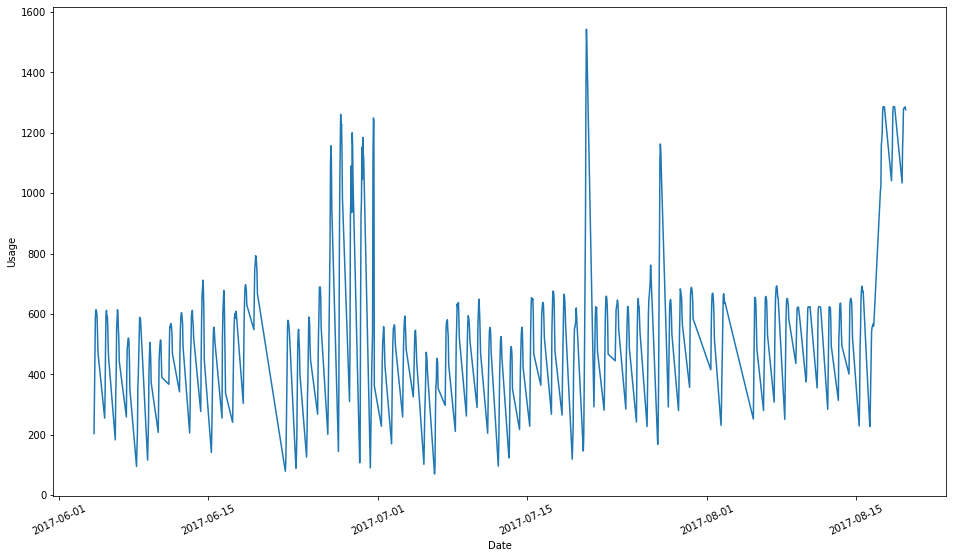

In [10]:
visualize_time_series_data(municipality_data)

### **First Base Model - Facebook Prophet**

In [11]:
def get_train_test_data(municipality_data):
    train_data = municipality_data[municipality_data.timestamp   < '2017-08-05']
    test_data  = municipality_data[municipality_data.timestamp  >= '2017-08-05']
    return train_data, test_data

In [12]:
def fit_predict_model(municipality_data, is_demo=True):
    train_data, test_data = get_train_test_data(municipality_data)
    m = Prophet().fit(train_data[["timestamp", "usage"]].rename(columns = {"timestamp":"ds", "usage":"y"}))
    future = pd.concat([train_data, test_data])[["timestamp"]].rename(columns = {"timestamp":"ds"})
    preds = m.predict(future)
    if is_demo:
        fig = m.plot(preds)
    return preds, test_data

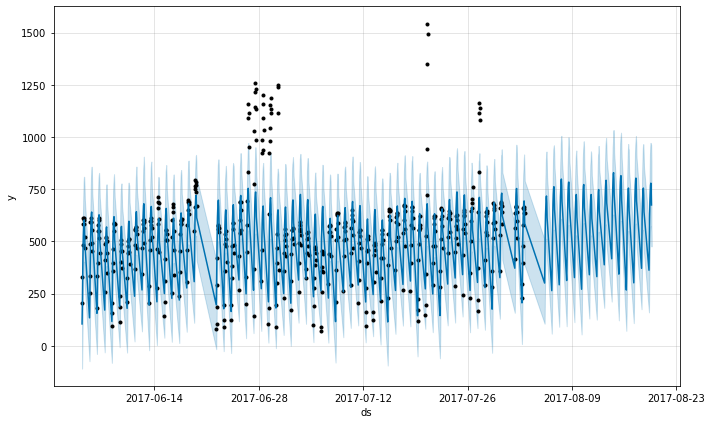

In [13]:
preds, test_data = fit_predict_model(municipality_data)

In [14]:
def get_model_error(test_data, preds):
    test_data["usage_preds"] = preds.yhat
    return "Facebook Prophet MSE is: {}".format(mean_squared_error(test_data.usage, test_data.usage_preds))

In [15]:
get_model_error(test_data, preds)

'Facebook Prophet MSE is: 73281.36481909882'

### **Time-Based Feature Extraction**

In [16]:
def createFeature(data) :
    data['hour']  =  data['timestamp'].dt.hour
    data['day']  =  data['timestamp'].dt.day
    data['month'] =  data['timestamp'].dt.month
    data['year']    =  data['timestamp'].dt.year
    data['dayofweek']  =  data['timestamp'].dt.weekday
    data['dayofyear']  =  data['timestamp'].dt.dayofyear
    data['weekofyear'] =  data['timestamp'].dt.weekofyear
    data['quarter']    =  data['timestamp'].dt.quarter
    
    return data

In [17]:
featured_municipality_data = createFeature(municipality_data.copy())
featured_municipality_data

,timestamp,municipality_id,total_capacity,usage,hour,day,month,year,dayofweek,dayofyear,weekofyear,quarter
0,2017-06-04 07:00:00,0,2813,204,7,4,6,2017,6,155,22,2
1,2017-06-04 08:00:00,0,2813,332,8,4,6,2017,6,155,22,2
2,2017-06-04 09:00:00,0,2813,485,9,4,6,2017,6,155,22,2
3,2017-06-04 10:00:00,0,2813,583,10,4,6,2017,6,155,22,2
4,2017-06-04 11:00:00,0,2813,614,11,4,6,2017,6,155,22,2
...,...,...,...,...,...,...,...,...,...,...,...,...
669,2017-08-19 12:00:00,0,2813,1281,12,19,8,2017,5,231,33,3
670,2017-08-19 13:00:00,0,2813,1283,13,19,8,2017,5,231,33,3
671,2017-08-19 14:00:00,0,2813,1285,14,19,8,2017,5,231,33,3
672,2017-08-19 15:00:00,0,2813,1286,15,19,8,2017,5,231,33,3


### **Second Model - XGB Regressor**

In [18]:
train_data, test_data = get_train_test_data(featured_municipality_data)
xgb = XGBRegressor()
xgb.fit(train_data[list(train_data.columns[4:])], train_data.usage)
 
# predict on the test period
preds = xgb.predict(test_data[list(test_data.columns[4:])])
test_data["usage_preds"] = preds
"XGB Regressor MSE is: {}".format(mean_squared_error(test_data.usage, test_data.usage_preds))

'XGB Regressor MSE is: 96784.50159797492'

### **Second Model - XGB Regressor with Hyperparameter**

In [19]:
params = {'learning_rate': 0.017659558136286068,
 'reg_lambda': 0.007463050468829971,
 'reg_alpha': 0.0713858474799285,
 'subsample': 0.5005741515919144,
 'colsample_bytree': 0.9831642464291973,
 'max_depth': 3,
 'early_stopping_rounds': 498,
 'n_estimators': 1250}

train_data, test_data = get_train_test_data(featured_municipality_data)
xgb = XGBRegressor(**params)
xgb.fit(train_data[list(train_data.columns[4:])], train_data.usage)
 
# predict on the test period
preds = xgb.predict(test_data[list(test_data.columns[4:])])
test_data["usage_preds"] = preds
"XGB Regressor with hyperparameter MSE is: {}".format(mean_squared_error(test_data.usage, test_data.usage_preds))

[00:15:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




'XGB Regressor with hyperparameter MSE is: 82654.67951349968'

### **Third Model - CatBoost Regressor**

In [20]:
train_data, test_data = get_train_test_data(featured_municipality_data)
cbt = CatBoostRegressor(verbose=0)
cbt.fit(train_data[list(train_data.columns[4:])], train_data.usage)
 
# predict on the test period
preds = cbt.predict(test_data[list(test_data.columns[4:])])
test_data["usage_preds"] = preds
"CatBoost Regressor MSE is: {}".format(mean_squared_error(test_data.usage, test_data.usage_preds))

'CatBoost Regressor MSE is: 83069.1019339525'

### **Third Model - CatBoost Regressor with Hyperparameter**

In [21]:
params = {'learning_rate': 0.017659558136286068,
 'reg_lambda': 0.007463050468829971,
 'subsample': 0.5005741515919144,
 'colsample_bylevel': 0.9831642464291973,
 'max_depth': 3,
 'early_stopping_rounds': 498,
 'verbose': 0,
 'n_estimators': 1250}

train_data, test_data = get_train_test_data(featured_municipality_data)
cbt = CatBoostRegressor(**params)
cbt.fit(train_data[list(train_data.columns[4:])], train_data.usage)
 
# predict on the test period
preds = cbt.predict(test_data[list(test_data.columns[4:])])
test_data["usage_preds"] = preds
"CatBoost Regressor with hyperparameter MSE is: {}".format(mean_squared_error(test_data.usage, test_data.usage_preds))

'CatBoost Regressor with hyperparameter MSE is: 76177.50038066172'

### **Fourth Model - LGBM Regressor**

In [22]:
train_data, test_data = get_train_test_data(featured_municipality_data)
lgbm = LGBMRegressor()
lgbm.fit(train_data[list(train_data.columns[4:])], train_data.usage)
 
# predict on the test period
preds = lgbm.predict(test_data[list(test_data.columns[4:])])
test_data["usage_preds"] = preds
"LGBM Regressor MSE is: {}".format(mean_squared_error(test_data.usage, test_data.usage_preds))

'LGBM Regressor MSE is: 70962.46530681309'

### **Fourth Model - LGBM Regressor with Hyperparameter**

In [23]:
params = {'learning_rate': 0.017659558136286068,
 'reg_lambda': 0.007463050468829971,
 'reg_alpha': 0.0713858474799285,
 'subsample': 0.5005741515919144,
 'colsample_bytree': 0.9831642464291973,
 'max_depth': 3,
 'n_estimators': 2250}

train_data, test_data = get_train_test_data(featured_municipality_data)
lgbm = LGBMRegressor(**params)
lgbm.fit(train_data[list(train_data.columns[4:])], train_data.usage)
 
# predict on the test period
preds = lgbm.predict(test_data[list(test_data.columns[4:])])
test_data["usage_preds"] = preds
"LGBM Regressor with hyperparameter MSE is: {}".format(mean_squared_error(test_data.usage, test_data.usage_preds))

'LGBM Regressor with hyperparameter MSE is: 65265.47681283969'

## **Get All Municipality Predictions**

In [24]:
def get_prophet_results(usage_data):
    results = []
    for m_id in range(10):
        municipality_data = get_municipality_data(usage_data, m_id)
        preds, test_data = fit_predict_model(municipality_data, False)
        test_data["usage_preds"] = preds.yhat
        results.append(mean_squared_error(test_data.usage, test_data.usage_preds))
    return results

In [25]:
prophet_results = get_prophet_results(usage_data)
prophet_results

[73281.36481909882,
 5113.068233194018,
 7846.670660126086,
 56752.84965385934,
 303321.624924595,
 4815.485174265904,
 74430.85437564418,
 38027.311201638644,
 46665.40624012648,
 13036.044166050251]

In [26]:
def get_xgboost_results(usage_data):
    results = []
    params = {'learning_rate': 0.017659558136286068,
                  'reg_lambda': 0.007463050468829971,
                  'reg_alpha': 0.0713858474799285,
                  'subsample': 0.5005741515919144,
                  'colsample_bytree': 0.9831642464291973,
                  'max_depth': 3,
                  'n_estimators': 1250}
    for m_id in range(10):
        municipality_data = get_municipality_data(usage_data, m_id)
        featured_municipality_data = createFeature(municipality_data)
        train_data, test_data = get_train_test_data(featured_municipality_data)
        xgb = XGBRegressor(**params)
        xgb.fit(train_data[list(train_data.columns[4:])], train_data.usage)
 
        # predict on the test period
        preds = xgb.predict(test_data[list(test_data.columns[4:])])
        test_data["usage_preds"] = preds
        results.append(mean_squared_error(test_data.usage, test_data.usage_preds))
    return results

In [27]:
xgboost_results = get_xgboost_results(usage_data)
xgboost_results

[82654.67951349968,
 1001.8090047028611,
 7202.854114327724,
 82375.82653232006,
 562376.6001176725,
 12054.127858161599,
 91672.3297111576,
 26064.667202548768,
 42344.52124855534,
 11303.919601613321]

In [28]:
def get_catboost_results(usage_data):
    results = []
    params = {'learning_rate': 0.017659558136286068,
                  'reg_lambda': 0.007463050468829971,
                  'subsample': 0.5005741515919144,
                  'colsample_bylevel': 0.9831642464291973,
                  'max_depth': 3,
                  'verbose': 0,
                  'n_estimators': 1250}
    for m_id in range(10):
        municipality_data = get_municipality_data(usage_data, m_id)
        featured_municipality_data = createFeature(municipality_data)
        train_data, test_data = get_train_test_data(featured_municipality_data)
        cbt = CatBoostRegressor(**params)
        cbt.fit(train_data[list(train_data.columns[4:])], train_data.usage)
 
        # predict on the test period
        preds = cbt.predict(test_data[list(test_data.columns[4:])])
        test_data["usage_preds"] = preds
        results.append(mean_squared_error(test_data.usage, test_data.usage_preds))
    return results

In [29]:
catboost_results = get_catboost_results(usage_data)
catboost_results

[76177.50038066172,
 937.2587591883977,
 6556.8368499811595,
 72137.36266529956,
 507652.2831260248,
 10415.191972145476,
 80830.47156261123,
 22370.6152466297,
 46789.74061942136,
 8082.229441792747]

In [30]:
def get_lgbm_results(usage_data):
    results = []
    params = {'learning_rate': 0.017659558136286068,
              'reg_lambda': 0.007463050468829971,
              'reg_alpha': 0.0713858474799285,
              'subsample': 0.5005741515919144,
              'colsample_bytree': 0.9831642464291973,
              'max_depth': 3,
              'n_estimators': 2250}
    for m_id in range(10):
        municipality_data = get_municipality_data(usage_data, m_id)
        featured_municipality_data = createFeature(municipality_data)
        train_data, test_data = get_train_test_data(featured_municipality_data)
        lgbm = LGBMRegressor(**params)
        lgbm.fit(train_data[list(train_data.columns[4:])], train_data.usage)
 
        # predict on the test period
        preds = lgbm.predict(test_data[list(test_data.columns[4:])])
        test_data["usage_preds"] = preds
        results.append(mean_squared_error(test_data.usage, test_data.usage_preds))
    return results

In [31]:
lgbm_results = get_lgbm_results(usage_data)
lgbm_results 

[65265.47681283969,
 1032.9241835846358,
 4683.058333625441,
 77133.17970429982,
 528256.137557592,
 11913.262920294696,
 68183.87733177954,
 26485.85280701536,
 37482.41591174757,
 10861.900478243393]

In [32]:
all_results = pd.DataFrame({ "Municipality_ID": [i for i in range(10)],
                             "Facebook_Prophet":prophet_results,
                             "XGBoost_Regressor":xgboost_results,
                             "CatBoost_Regressor":catboost_results,
                             "LGBM_Regressor":lgbm_results})

all_results['Best_Model'] = all_results[['Facebook_Prophet', 'XGBoost_Regressor', 'CatBoost_Regressor', 'LGBM_Regressor']].idxmin(axis=1)
all_results

,Municipality_ID,Facebook_Prophet,XGBoost_Regressor,CatBoost_Regressor,LGBM_Regressor,Best_Model
0,0,73281.364819,82654.679513,76177.500381,65265.476813,LGBM_Regressor
1,1,5113.068233,1001.809005,937.258759,1032.924184,CatBoost_Regressor
2,2,7846.670660,7202.854114,6556.836850,4683.058334,LGBM_Regressor
3,3,56752.849654,82375.826532,72137.362665,77133.179704,Facebook_Prophet
4,4,303321.624925,562376.600118,507652.283126,528256.137558,Facebook_Prophet
5,5,4815.485174,12054.127858,10415.191972,11913.262920,Facebook_Prophet
6,6,74430.854376,91672.329711,80830.471563,68183.877332,LGBM_Regressor
7,7,38027.311202,26064.667203,22370.615247,26485.852807,CatBoost_Regressor
8,8,46665.406240,42344.521249,46789.740619,37482.415912,LGBM_Regressor
9,9,13036.044166,11303.919602,8082.229442,10861.900478,CatBoost_Regressor
